<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/ESRGAN_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses a pre-trained [Enhanced Super Resolution GAN](https://arxiv.org/abs/1809.00219) model from TensorFlow Hub ([here](https://tfhub.dev/captain-pool/esrgan-tf2/1)), converts it to a TensorFlow Lite (TF Lite) model (**4.8 MBs** only), and then shows how to run demo inference with the TensorFlow Lite model using the TF Lite interpreter. A big thanks to [Adrish](https://twitter.com/captain__pool) (who developed this model during GSoC 2019) for helping.

## Setup

In [1]:
!pip uninstall -q tensorflow
!pip install -q tf-nightly

Proceed (y/n)? Y
     |████████████████████████████████| 525.1MB 27kB/s 
     |████████████████████████████████| 2.9MB 45.2MB/s 
     |████████████████████████████████| 460kB 43.8MB/s 


## Retrieve the pre-trained ESRGAN model checkpoints

In [0]:
!wget https://tfhub.dev/captain-pool/esrgan-tf2/1?tf-hub-format=compressed 

## Untar the checkpoints

In [3]:
!mkdir saved_model_esrgan
!tar -C /content/saved_model_esrgan -xvf 1?tf-hub-format=compressed

./
./variables/
./variables/variables.data-00000-of-00001
./variables/variables.index
./saved_model.pb


## Model conversion

In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.0-dev20200601


In [0]:
model = tf.saved_model.load('saved_model_esrgan')
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

concrete_func.inputs[0].set_shape([1, 512 // 4, 512 // 4, 3]) 

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

## Serialize the TF Lite model and investigate its size

In [9]:
with tf.io.gfile.GFile('esrgan.tflite', 'wb') as f:
    f.write(tflite_model)

!ls -lh esrgan.tflite

-rw-r--r-- 1 root root 4.8M Jun  1 11:21 esrgan.tflite


## Running inference

In [7]:
# Gather a sample image
!wget https://gratisography.com/wp-content/uploads/2020/03/gratisography-old-building-corner-1170x780.jpg -O image.jpg

--2020-06-01 11:20:32--  https://gratisography.com/wp-content/uploads/2020/03/gratisography-old-building-corner-1170x780.jpg
Resolving gratisography.com (gratisography.com)... 104.28.6.77, 172.67.132.204, 104.28.7.77, ...
Connecting to gratisography.com (gratisography.com)|104.28.6.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.jpg’

image.jpg               [ <=>                ] 258.84K  --.-KB/s    in 0.04s   

2020-06-01 11:20:32 (6.46 MB/s) - ‘image.jpg’ saved [265052]



Bicubic downsampling is needed since the model was trained on bicubically downsampled images. 

In [0]:
# Utility for image loading and preprocessing
import numpy as np
import PIL

def load_img(path_to_img, scale_factor=4, save_path="downsampled_image.jpg"):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = img.numpy()
    hr = img = PIL.Image.fromarray(img)
    if not scale_factor:
      width, height = 512, 512
      scale_factor = 4
    else:
      width, height = img.size
    if save_path:
      lr = img = img.resize(
          (width // scale_factor, height // scale_factor),
          PIL.Image.BICUBIC)
      lr.save(save_path)
    img = np.asarray(img)
    img = tf.cast(img, dtype=tf.float32)
    img = img[tf.newaxis, :]
    return img

In [36]:
low_res_image = load_img('image.jpg', None)
low_res_image.shape.as_list()

[1, 128, 128, 3]

In [0]:
# Load the image.
low_res_image = load_img('downsampled_image.jpg', None, None)

# Load the model.
interpreter = tf.lite.Interpreter(model_path='esrgan.tflite')

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Invoke the interpreter to run inference.
interpreter.set_tensor(input_details[0]['index'], low_res_image)
interpreter.invoke()

# Retrieve the enhanced image.
enhanced_img = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

## Visualize results

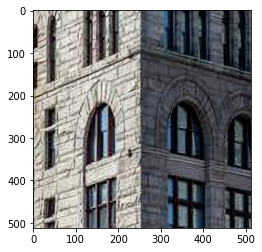

In [14]:
import matplotlib.pyplot as plt

a = tf.cast(tf.clip_by_value(enhanced_img[0], 0, 255), tf.uint8)
plt.imshow(a)
plt.show()

In [0]:
from PIL import Image

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

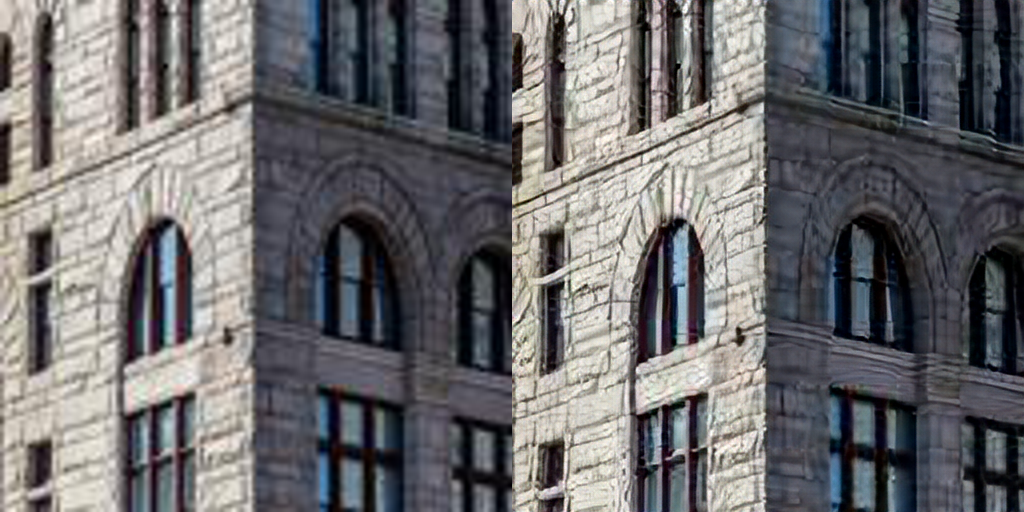

In [16]:
super_resolution_img = Image.fromarray(a.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((512, 512))

down_sampled_image = Image.open('/content/downsampled_image.jpg').resize((512, 512))

get_concat_h(down_sampled_image, super_resolution_img)

## Comparison with the original TF Hub model

In [0]:
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
low_resolution_image = load_img('image.jpg')
super_resolution = model(low_resolution_image) 

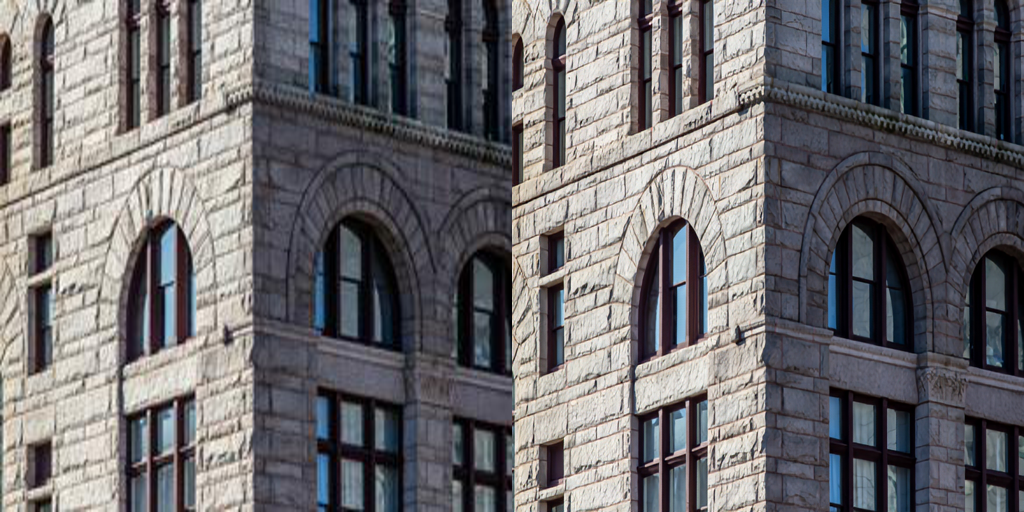

In [21]:
super_resolution_processed = tf.cast(tf.clip_by_value(super_resolution[0], 0, 255), tf.uint8)

super_resolution_img = Image.fromarray(super_resolution_processed.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((512, 512))

down_sampled_image = Image.open('/content/downsampled_image.jpg').resize((512, 512))

get_concat_h(down_sampled_image, super_resolution_img)

## Inference with the distilled version of the model (33 KB)

In [0]:
!wget https://github.com/captain-pool/GSOC/releases/download/2.0.0/compressed_esrgan.tflite

In [31]:
!ls -lh compressed_esrgan.tflite

-rw-r--r-- 1 root root 33K Aug 26  2019 compressed_esrgan.tflite


In [0]:
# Utility for image loading and preprocessing
import numpy as np
import PIL

def load_img_dis(path_to_img, downsample=True, save_path="downsampled_image.jpg"):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = img.numpy()
    img = PIL.Image.fromarray(img)
    if downsample:
        img = img.resize((320, 180), PIL.Image.BICUBIC) 
        # Shape referred from here: https://github.com/captain-pool/GSOC/tree/master/E3_Distill_ESRGAN
    if save_path:
        img.save(save_path)
    img = np.asarray(img)
    img = tf.cast(img, dtype=tf.float32)
    img = img[tf.newaxis, :]
    return img

In [45]:
low_res_image = load_img_dis('image.jpg', True, None)
low_res_image.shape.as_list()

[1, 180, 320, 3]

In [0]:
# Load the image.
low_res_image = load_img('downsampled_image.jpg', False, None)

# Load the model.
interpreter = tf.lite.Interpreter(model_path='compressed_esrgan.tflite')

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Invoke the interpreter to run inference.
interpreter.set_tensor(input_details[0]['index'], low_res_image)
interpreter.invoke()

# Retrieve the enhanced image.
enhanced_img = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

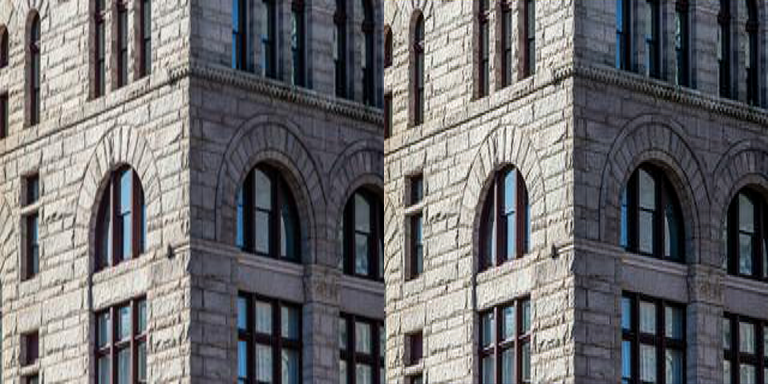

In [52]:
a = tf.cast(tf.clip_by_value(enhanced_img[0], 0, 255), tf.uint8)
super_resolution_img = Image.fromarray(a.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((384, 384))

down_sampled_image = Image.open('/content/downsampled_image.jpg').resize((384, 384))

get_concat_h(down_sampled_image, super_resolution_img)